In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import trange

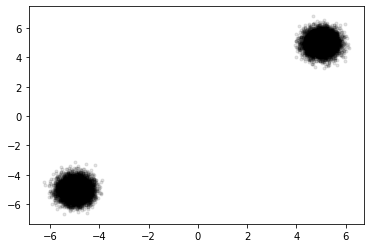

In [2]:
mu1 = np.array([5, 5])
sigma1 = np.array([[0.1, 0], [0, 0.2]])
X1 = np.random.multivariate_normal(mean=mu1, cov=sigma1, size=10000)

mu2 = np.array([-5, -5])
sigma2 = np.array([[0.1, 0], [0, 0.2]])
X2 = np.random.multivariate_normal(mean=mu2, cov=sigma2, size=10000)

X = np.concatenate([X1, X2])

plt.scatter(X[:, 0], X[:, 1], marker='.', color='k', alpha=0.1)
plt.show()

In [3]:
dataset = TensorDataset(torch.tensor(X).float())
dataloader = DataLoader(dataset, batch_size=16, pin_memory=True, shuffle=True)

In [8]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.act = nn.Sigmoid()
        self.fc2 = nn.Linear(16, 2)

    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

model = MLP().cuda()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)
loss_fn = nn.MSELoss()

Training progress:   0%|          | 0/20000 [00:00<?, ?it/s]

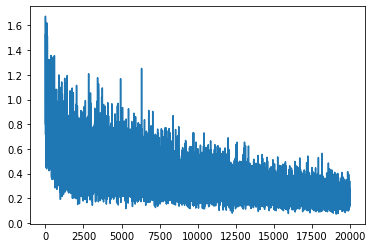

In [9]:
max_iter = 20000
sigma = 1.0

step = 0
losses = []

with trange(max_iter, desc=f"Training progress") as t:
    for _ in range(9999):
        for x in dataloader:
            step += 1

            x = x[0].cuda()
            noise = sigma * torch.randn_like(x, device=x.device)
            x_noised = x + noise

            score_estimate = model(x_noised)
            score = (- 1 / sigma ** 2) * noise
            loss = loss_fn(score_estimate, score)

            losses.append(loss.item())
            t.set_postfix(loss=loss.item())
            t.update()

            if step >= max_iter:
                break

            for p in model.parameters():
                p.grad = None
            loss.backward()
            optimizer.step()

        if step >= max_iter:
            break

plt.plot(losses)
plt.show()

In [41]:
model.eval()

n_points = 10
ld_iters = 5000
path_arr = np.zeros((n_points, ld_iters, 2))
eps = 0.001
sigma_small = 0.01
x = 12 * np.random.rand(n_points, 2) - 6
path_arr[:, 0, :] = x

for i in range(1, ld_iters):
    x_tensor = torch.tensor(x).float().cuda()
    du = model(x_tensor).cpu().detach().numpy()
    x += eps * du + np.sqrt(2 * eps) * sigma_small * np.random.random(x.shape)
    path_arr[:, i, :] = x

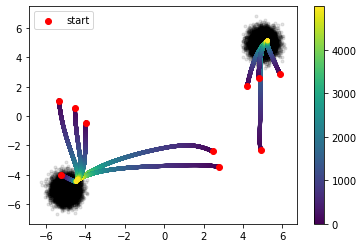

In [42]:
plt.scatter(X[:, 0], X[:, 1], marker='.', color='k', alpha=0.1)
for i in range(n_points):
    plt.scatter(path_arr[i, :, 0], path_arr[i, :, 1], c=np.arange(ld_iters), marker='.')
plt.colorbar()
plt.scatter(path_arr[:, 0, 0], path_arr[:, 0, 1], color='red', marker='o', label='start')
plt.legend(loc='upper left')
plt.show()